In [77]:
from math import sqrt
import pandas as pd
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
import datetime
from sklearn import metrics
from numpy import concatenate
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [32]:
dataset = pd.read_csv('dataset.csv')
dataset.set_index(['date','sex','age','height','timezone'], inplace=True)
dataset.head()
#dataset.shape

,,,,,steps,bedin,bedout,sleep duration,deepduration,lightduration
date,sex,age,height,timezone,,,,,,
2016-04-02,1.0,39.0,174.0,1.0,2547.55,23.78,7.82,7.76,3.24,4.49
2016-04-03,1.0,39.0,174.0,1.0,329.53,23.41,6.48,6.93,2.54,4.38
2016-04-05,1.0,39.0,174.0,1.0,9031.89,22.95,6.73,7.19,3.04,4.14
2016-04-06,1.0,39.0,174.0,1.0,15331.70,22.44,6.18,7.61,3.51,4.14
2016-04-07,1.0,39.0,174.0,1.0,5222.45,24.57,4.04,3.38,1.92,1.49


In [85]:
#Normalizzazione
x_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()

x_data = x_scaler.fit_transform(dataset[['steps','bedin','bedout','sleep duration','deepduration','lightduration']])
y_data = y_scaler.fit_transform(dataset[['sleep duration']])

In [114]:
def custom_ts_multi_data_prep(dataset, target, start, end, window, horizon):
    X = []
    y = []
    start = start + window
    if end is None:
        end = len(dataset) - horizon

    for i in range(start, end):
        indices = range(i-window, i)
        X.append(dataset[indices])

        indicey = range(i+1, i+1+horizon)
        y.append(target[indicey])
    return np.array(X), np.array(y)

In [103]:
hist_window = 7
horizon = 1
TRAIN_SPLIT = 30000
x_train, y_train =custom_ts_multi_data_prep(x_data, y_data, 0, TRAIN_SPLIT, hist_window, horizon) #np.array(x_data[:100000]),np.array(y_data[:100000]
x_vali, y_vali =custom_ts_multi_data_prep(x_data, y_data, TRAIN_SPLIT, None, hist_window, horizon) # np.array(x_data[100001:200000]),np.array(y_data[100001:200000])


In [110]:
y_train.shape

(29993, 1, 1)

In [113]:
y_train[0]

array([[0.02460528]])

In [116]:
batch_size = 256
buffer_size = 150

train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.cache().shuffle(buffer_size).batch(batch_size).repeat()

val_data = tf.data.Dataset.from_tensor_slices((x_vali, y_vali))
val_data = val_data.batch(batch_size).repeat()

In [117]:
lstm_model = tf.keras.models.Sequential([
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(200, return_sequences=True), 
                               input_shape=x_train.shape[-2:]),
    tf.keras.layers.Dense(20, activation='tanh'),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(150)),
    tf.keras.layers.Dense(20, activation='tanh'),
    tf.keras.layers.Dense(20, activation='tanh'),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(units=horizon),
])
lstm_model.compile(optimizer='adam', loss='mse')


In [118]:
lstm_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_6 (Bidirectio  (None, 7, 400)           331200    
 nal)                                                            
                                                                 
 dense_13 (Dense)            (None, 7, 20)             8020      
                                                                 
 bidirectional_7 (Bidirectio  (None, 300)              205200    
 nal)                                                            
                                                                 
 dense_14 (Dense)            (None, 20)                6020      
                                                                 
 dense_15 (Dense)            (None, 20)                420       
                                                                 
 dropout_3 (Dropout)         (None, 20)               

In [119]:
history = lstm_model.fit(train_data,epochs=150,steps_per_epoch=100,validation_data=val_data,validation_steps=50,verbose=1)

Epoch 1/150
100/100 [==============================] - 23s 172ms/step - loss: 2.1736e-04 - val_loss: 8.0410e-05
Epoch 2/150
100/100 [==============================] - 16s 161ms/step - loss: 9.8243e-05 - val_loss: 7.1423e-05
Epoch 3/150
 40/100 [===========>..................] - ETA: 8s - loss: 1.0378e-04

KeyboardInterrupt: 

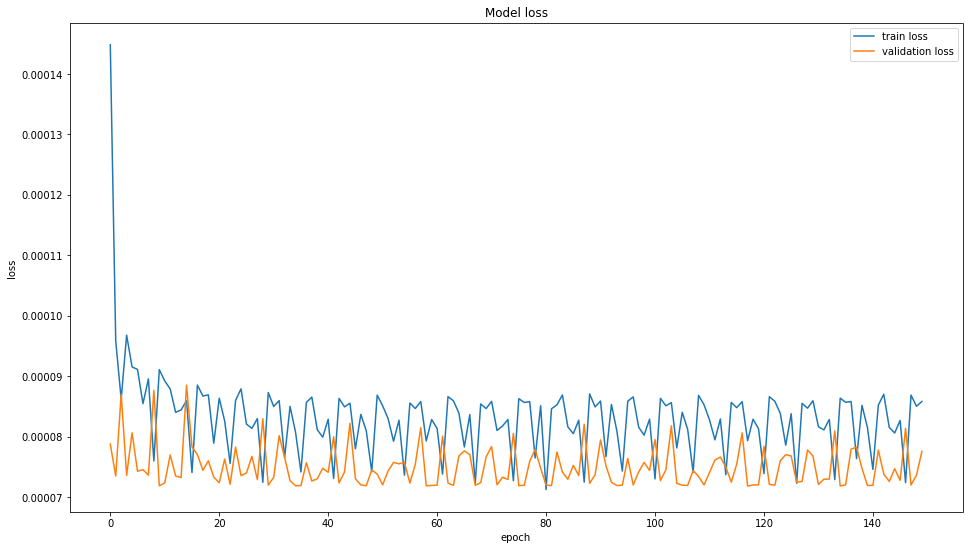

In [56]:
plt.figure(figsize=(16,9))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'validation loss'])
plt.show()

In [63]:
data_val = x_scaler.fit_transform(dataset[['steps','bedin','bedout','sleep duration','deepduration','lightduration']].tail(1))
val_rescaled = data_val.reshape(1, data_val.shape[0], data_val.shape[1])

In [64]:
pred = lstm_model.predict(val_rescaled)
pred

1/1 [==============================] - 1s 1s/step


array([[0.03335526]], dtype=float32)

In [66]:
pred_Inverse = y_scaler.inverse_transform(pred)
pred_Inverse

array([[7.4152083]], dtype=float32)

In [73]:
def timeseries_evaluation_metrics_func(y_true, y_pred):
    def mean_absolute_percentage_error(y_true, y_pred): 
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print('Evaluation metric results:-')
    print(f'MSE is : {metrics.mean_squared_error(y_true, y_pred)}')
    print(f'MAE is : {metrics.mean_absolute_error(y_true, y_pred)}')
    print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    print(f'MAPE is : {mean_absolute_percentage_error(y_true, y_pred)}')
    print(f'R2 is : {metrics.r2_score(y_true, y_pred)}',end='\n\n')

In [75]:
pred_Inverse[0]

array([7.4152083], dtype=float32)

In [83]:
validate = dataset[['steps','bedin','bedout','sleep duration','deepduration','lightduration']].tail(10)

In [84]:
timeseries_evaluation_metrics_func(validate['sleep duration'],pred_Inverse[0])

Evaluation metric results:-


ValueError: Found input variables with inconsistent numbers of samples: [10, 1]

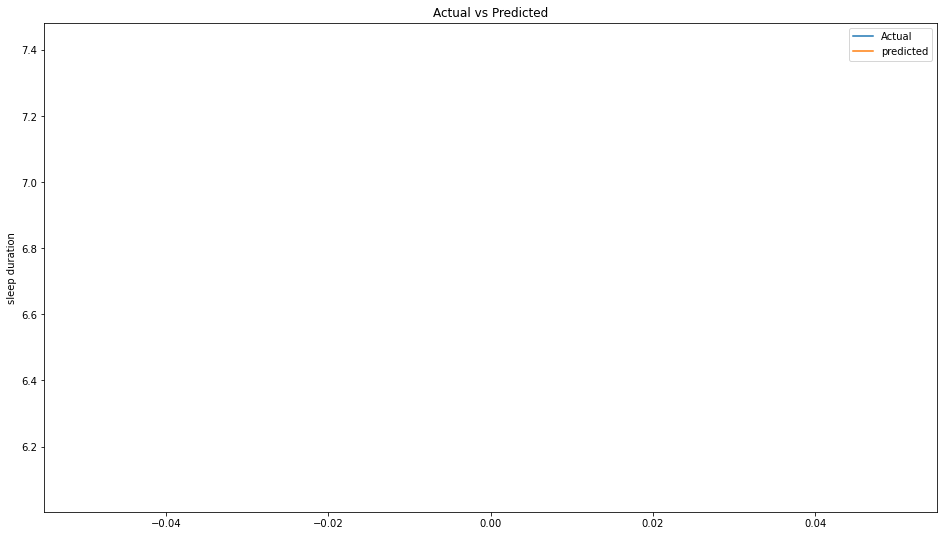

In [82]:
plt.figure(figsize=(16,9))
plt.plot( list(validate['sleep duration']))
plt.plot( list(pred_Inverse[0]))
plt.title("Actual vs Predicted")
plt.ylabel("sleep duration")
plt.legend(('Actual','predicted'))
plt.show()